# Railway Depot Thermal Balance Analysis (Simplified)

**Quick Analysis**: Determine heating requirements for a railway depot
- **Target**: 16°C indoor temperature
- **Outside**: -3°C
- **Building**: 100m × 38m × 7.15m
- **Panel Power**: 36.3 kW each

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

# Building parameters
L, W, H = 100, 38, 7.15  # dimensions (m)
T_target, T_init, T_out = 16, 8, -3  # temperatures (°C)
P_panel = 36266  # panel power (W)

# Areas and volumes
A_floor = A_roof = L * W
A_wall = 2 * H * (L + W)
A_window = 0.5 * H * L * 2  # 50% of long sides
A_shutter = 22.5 * 5
A_solid = A_wall - A_window - A_shutter
V_air = L * W * H

# U-values (W/m²·K)
U_wall, U_window, U_shutter, U_roof, U_floor = 1.6, 5.0, 4.5, 5.0, 1.5

# Thermal properties
rho_air, cp_air = 1.225, 1005  # kg/m³, J/kg·K
C_air = V_air * rho_air * cp_air  # Air thermal capacity
C_ground = A_floor * 120e3  # Ground thermal capacity
C_total = C_air + C_ground

print(f"Building: {L}×{W}×{H:.1f}m = {V_air:,.0f} m³")
print(f"Areas: Floor={A_floor:,.0f}, Walls={A_solid:.0f}, Windows={A_window:.0f}, Roof={A_roof:,.0f} m²")
print(f"Thermal capacity: Air={C_air/1e6:.1f} MJ/K, Ground={C_ground/1e6:.1f} MJ/K")

Building: 100×38×7.2m = 27,170 m³
Areas: Floor=3,800, Walls=1146, Windows=715, Roof=3,800 m²
Thermal capacity: Air=33.4 MJ/K, Ground=456.0 MJ/K


In [2]:
def heat_loss(dT, ach=5):
    """Calculate total heat loss (W) for temperature difference dT"""
    # Conduction loss
    Q_cond = (A_solid*U_wall + A_window*U_window + A_shutter*U_shutter + 
              A_roof*U_roof + A_floor*U_floor) * dT
    
    # Ventilation loss
    Q_vent = (ach * V_air / 3600) * rho_air * cp_air * dT if ach > 0 else 0
    
    return Q_cond, Q_vent, Q_cond + Q_vent

def simulate(n_panels, ach=5, hours=24):
    """Simulate heating with n_panels for given hours"""
    steps = hours
    temps = np.zeros(steps + 1)
    temps[0] = T_init
    
    for t in range(steps):
        dT = temps[t] - T_out
        _, _, Q_loss = heat_loss(dT, ach)
        Q_net = n_panels * P_panel - Q_loss
        temps[t+1] = temps[t] + Q_net * 3600 / C_total
    
    return temps

def find_panels_needed(ach=5, max_panels=50):
    """Find minimum panels needed for target temperature"""
    for n in range(1, max_panels + 1):
        if simulate(n, ach)[-1] >= T_target:
            return n
    return -1

print("Heat loss functions defined")

Heat loss functions defined


## Analysis 1: Panels Needed for 16°C

=== PANELS NEEDED FOR 16°C ===
With ventilation (5 ACH): 41 panels (1487 kW)
Without ventilation: 17 panels (617 kW)
Ventilation penalty: 24 additional panels


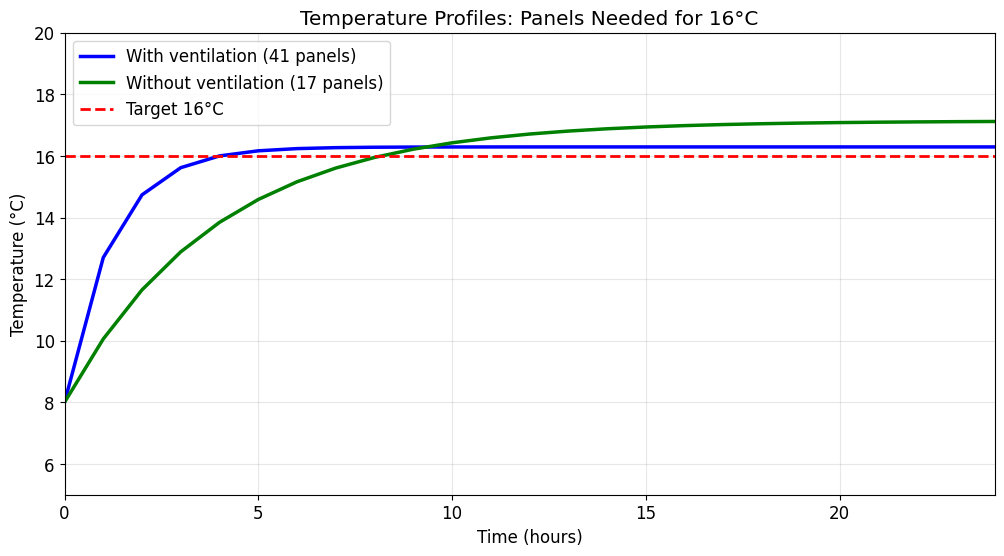

In [3]:
# Find panels needed
panels_vent = find_panels_needed(ach=5)
panels_no_vent = find_panels_needed(ach=0)

print("=== PANELS NEEDED FOR 16°C ===")
print(f"With ventilation (5 ACH): {panels_vent} panels ({panels_vent * P_panel/1000:.0f} kW)")
print(f"Without ventilation: {panels_no_vent} panels ({panels_no_vent * P_panel/1000:.0f} kW)")
print(f"Ventilation penalty: {panels_vent - panels_no_vent} additional panels")

# Plot temperature profiles
time = np.arange(25)
temps_vent = simulate(panels_vent, ach=5)
temps_no_vent = simulate(panels_no_vent, ach=0)

plt.figure(figsize=(12, 6))
plt.plot(time, temps_vent, 'b-', linewidth=2.5, label=f'With ventilation ({panels_vent} panels)')
plt.plot(time, temps_no_vent, 'g-', linewidth=2.5, label=f'Without ventilation ({panels_no_vent} panels)')
plt.axhline(T_target, color='red', linestyle='--', label='Target 16°C', linewidth=2)
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Profiles: Panels Needed for 16°C')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 24)
plt.ylim(5, 20)
plt.show()

## Analysis 2: Temperature with 12 Panels

=== 12 PANELS ANALYSIS ===
Total power: 435.2 kW
Final temp with ventilation: 2.6°C
Final temp without ventilation: 11.2°C
Temperature benefit of no ventilation: 8.6°C
Shortfall from target: 4.8°C

Heat balance at 16°C:
Heating power: 435.2 kW
Conduction loss: 581.7 kW
Ventilation loss: 882.7 kW
Total loss: 1464.4 kW
Power deficit: 1029.2 kW


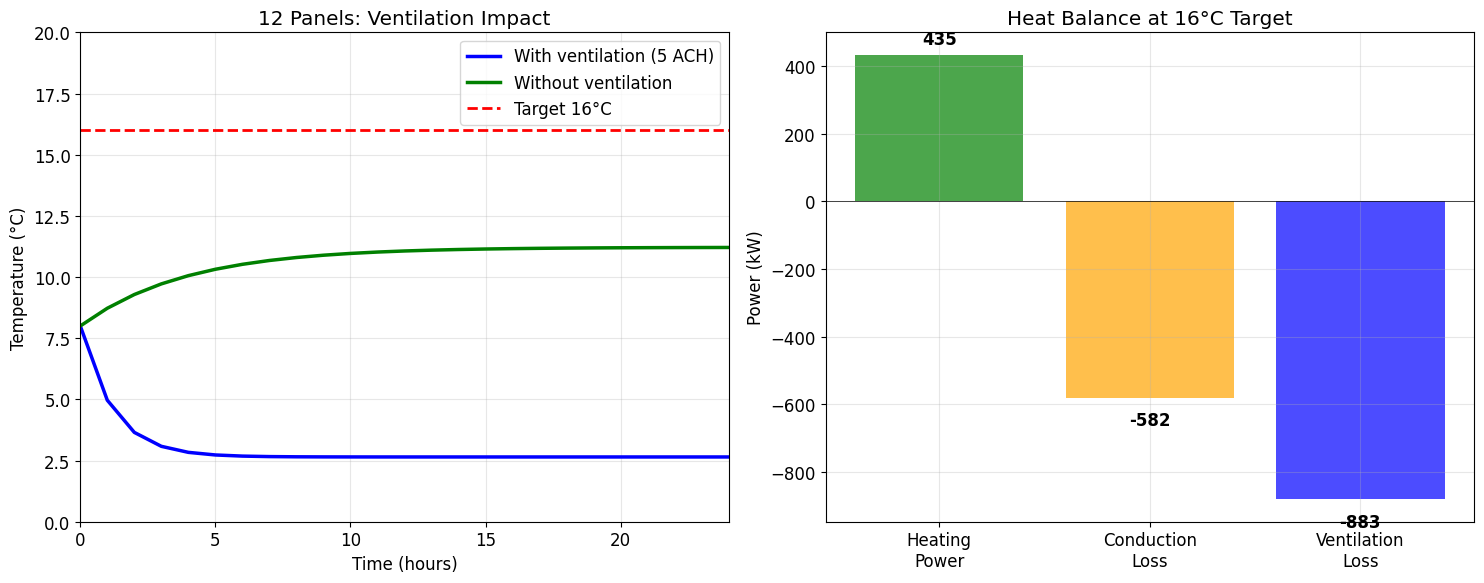

In [4]:
# Analyze 12 panels
n_panels = 12
temps_12_vent = simulate(n_panels, ach=5)
temps_12_no_vent = simulate(n_panels, ach=0)
final_vent = temps_12_vent[-1]
final_no_vent = temps_12_no_vent[-1]

print("=== 12 PANELS ANALYSIS ===")
print(f"Total power: {n_panels * P_panel/1000:.1f} kW")
print(f"Final temp with ventilation: {final_vent:.1f}°C")
print(f"Final temp without ventilation: {final_no_vent:.1f}°C")
print(f"Temperature benefit of no ventilation: {final_no_vent - final_vent:.1f}°C")
print(f"Shortfall from target: {T_target - final_no_vent:.1f}°C")

# Heat balance at 16°C
dT_target = T_target - T_out
Q_cond, Q_vent, Q_total = heat_loss(dT_target, ach=5)
Q_heating = n_panels * P_panel

print(f"\nHeat balance at 16°C:")
print(f"Heating power: {Q_heating/1000:.1f} kW")
print(f"Conduction loss: {Q_cond/1000:.1f} kW")
print(f"Ventilation loss: {Q_vent/1000:.1f} kW")
print(f"Total loss: {Q_total/1000:.1f} kW")
print(f"Power deficit: {(Q_total - Q_heating)/1000:.1f} kW")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temperature profiles
ax1.plot(time, temps_12_vent, 'b-', linewidth=2.5, label='With ventilation (5 ACH)')
ax1.plot(time, temps_12_no_vent, 'g-', linewidth=2.5, label='Without ventilation')
ax1.axhline(T_target, color='red', linestyle='--', label='Target 16°C', linewidth=2)
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('12 Panels: Ventilation Impact')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(0, 24)
ax1.set_ylim(0, 20)

# Heat balance
categories = ['Heating\nPower', 'Conduction\nLoss', 'Ventilation\nLoss']
values = [Q_heating/1000, -Q_cond/1000, -Q_vent/1000]
colors = ['green', 'orange', 'blue']

bars = ax2.bar(categories, values, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Power (kW)')
ax2.set_title('Heat Balance at 16°C Target')
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (20 if height > 0 else -40),
             f'{value:.0f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

## Analysis 3: Insulation Requirements for 12 Panels

=== INSULATION REQUIREMENTS FOR 12 PANELS ===
5 ACH: IMPOSSIBLE - ventilation loss exceeds heating power
3 ACH: IMPOSSIBLE - ventilation loss exceeds heating power
2 ACH: 85.9% insulation improvement needed
1 ACH: 55.5% insulation improvement needed
0.5 ACH: 40.4% insulation improvement needed
0 ACH: 25.2% insulation improvement needed


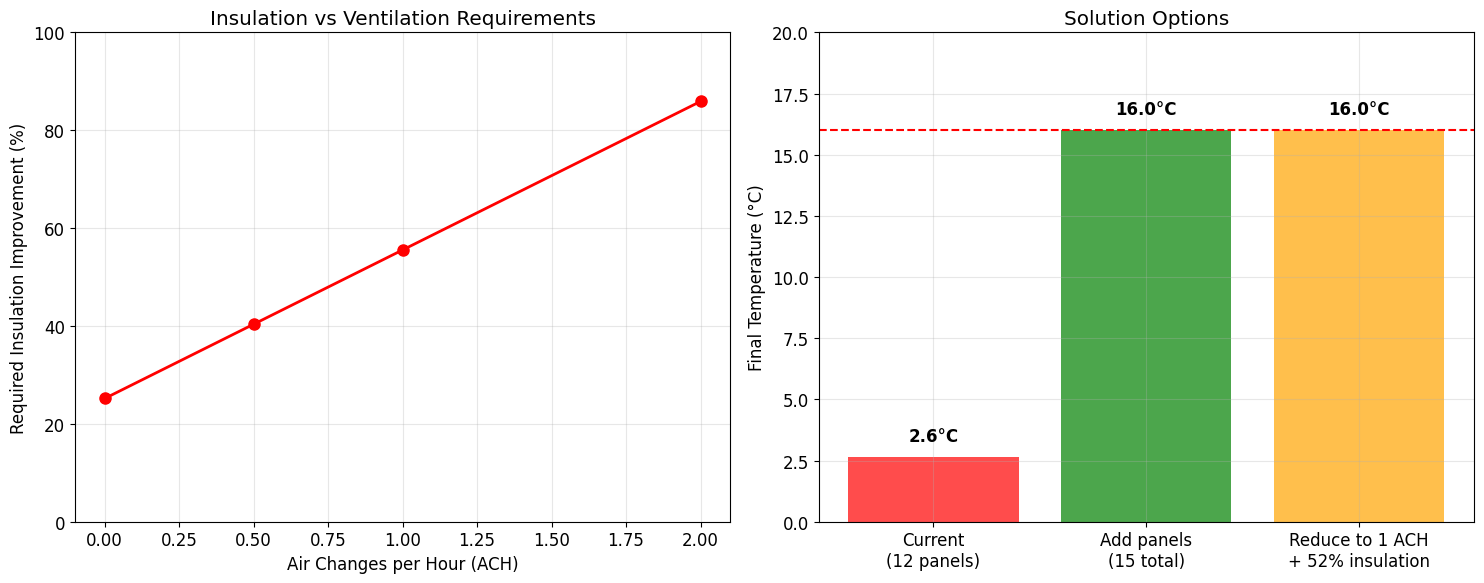

In [5]:
# Analyze insulation requirements
def insulation_analysis(n_panels=12):
    """Calculate insulation improvements needed for different ventilation rates"""
    Q_heating = n_panels * P_panel
    dT = T_target - T_out
    results = {}
    
    for ach in [5, 3, 2, 1, 0.5, 0]:
        Q_cond, Q_vent, Q_total = heat_loss(dT, ach)
        
        # Power available for conduction after ventilation
        Q_available = Q_heating - Q_vent
        
        if Q_available <= 0:
            results[ach] = {'possible': False, 'reduction': 0}
        else:
            # Required reduction in conduction loss
            reduction = max(0, (Q_cond - Q_available) / Q_cond * 100)
            results[ach] = {'possible': True, 'reduction': reduction}
    
    return results

# Calculate requirements
results = insulation_analysis()

print("=== INSULATION REQUIREMENTS FOR 12 PANELS ===")
for ach, result in results.items():
    if result['possible']:
        print(f"{ach} ACH: {result['reduction']:.1f}% insulation improvement needed")
    else:
        print(f"{ach} ACH: IMPOSSIBLE - ventilation loss exceeds heating power")

# Plot requirements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Insulation vs ventilation
ach_vals = [ach for ach, r in results.items() if r['possible']]
reduction_vals = [r['reduction'] for r in results.values() if r['possible']]

ax1.plot(ach_vals, reduction_vals, 'ro-', linewidth=2, markersize=8)
ax1.set_xlabel('Air Changes per Hour (ACH)')
ax1.set_ylabel('Required Insulation Improvement (%)')
ax1.set_title('Insulation vs Ventilation Requirements')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Solution comparison
solutions = ['Current\n(12 panels)', 'Add panels\n(15 total)', 'Reduce to 1 ACH\n+ 52% insulation']
temps = [final_vent, 16, 16]
colors = ['red', 'green', 'orange']

bars = ax2.bar(solutions, temps, color=colors, alpha=0.7)
ax2.axhline(T_target, color='red', linestyle='--', label='Target 16°C')
ax2.set_ylabel('Final Temperature (°C)')
ax2.set_title('Solution Options')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 20)

for bar, temp in zip(bars, temps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{temp:.1f}°C', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Summary Dashboard

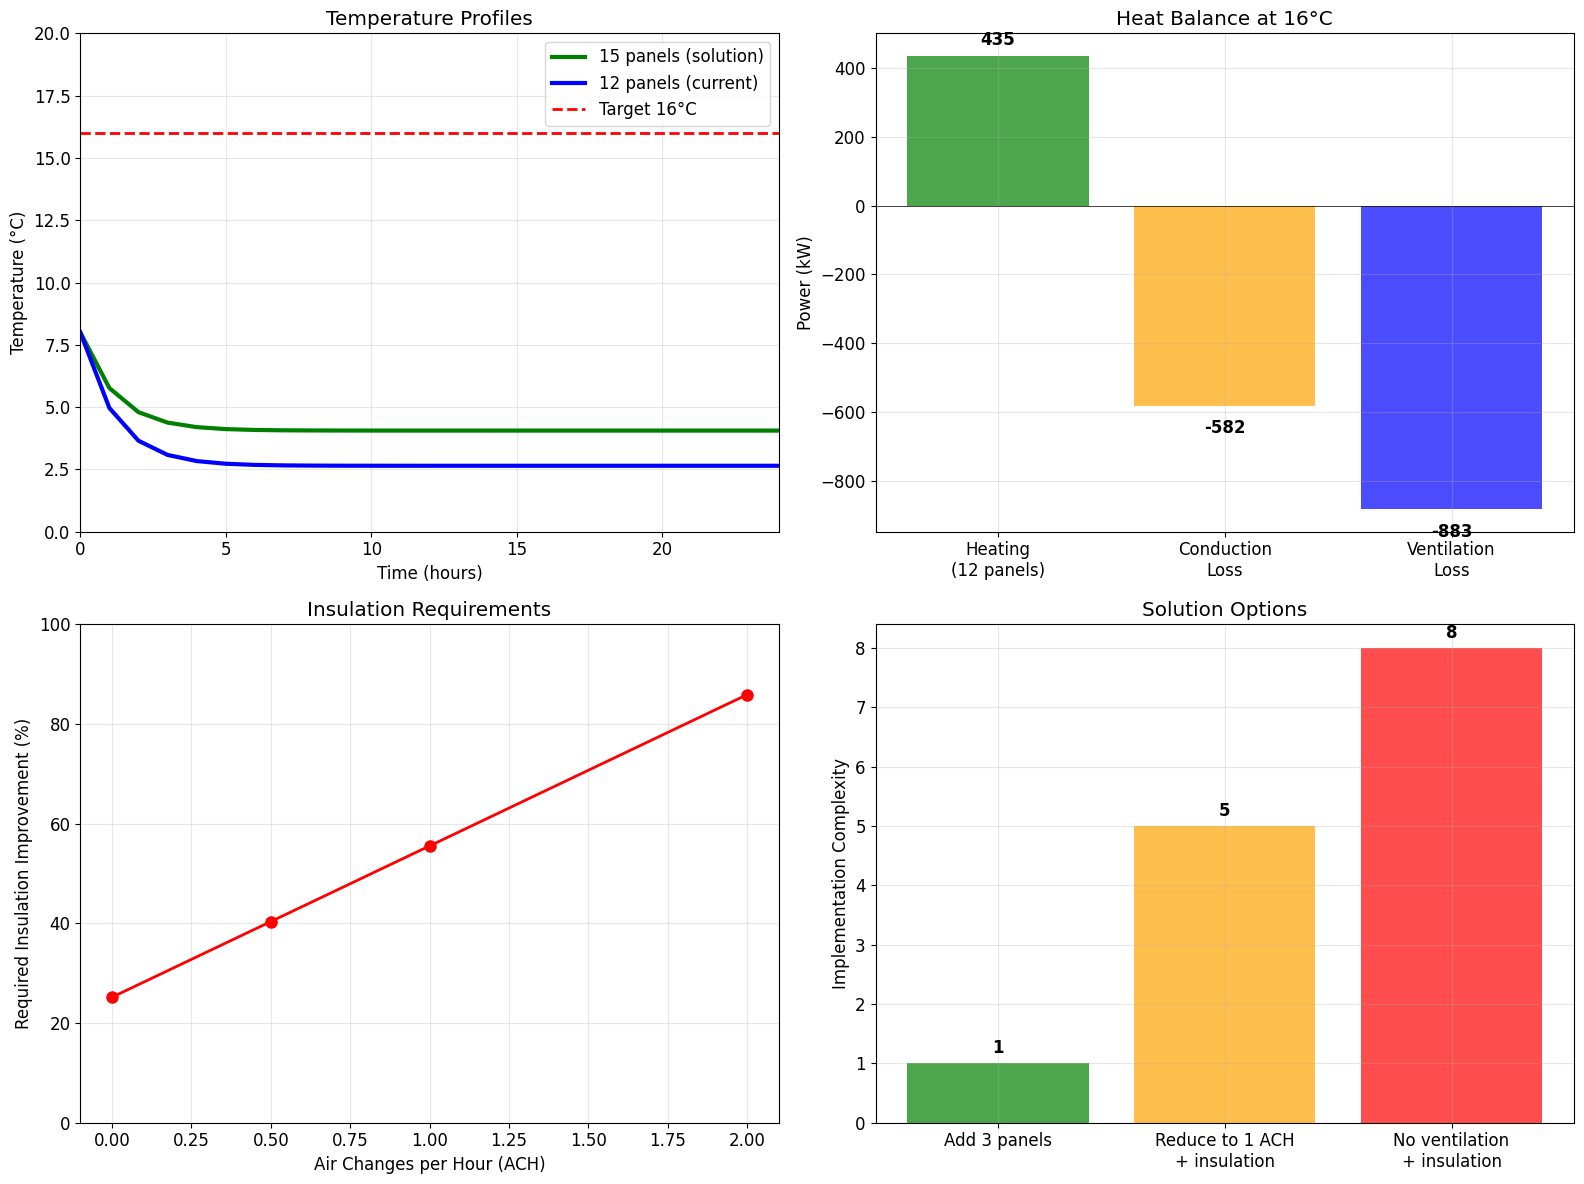


THERMAL ANALYSIS SUMMARY
1. TARGET: 16°C with -3°C outside
2. PANELS NEEDED: 41 panels with ventilation
3. WITH 12 PANELS: 2.6°C achieved (13.4°C shortfall)
4. SOLUTIONS:
   • Add 29 panels (simplest)
   • Reduce to 1 ACH + 52% insulation improvement
   • Eliminate ventilation + 27% insulation improvement


In [6]:
# Create comprehensive summary
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Temperature comparison
ax1.plot(time, simulate(15, ach=5), 'g-', linewidth=3, label='15 panels (solution)')
ax1.plot(time, simulate(12, ach=5), 'b-', linewidth=3, label='12 panels (current)')
ax1.axhline(T_target, color='red', linestyle='--', linewidth=2, label='Target 16°C')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature Profiles')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(0, 24)
ax1.set_ylim(0, 20)

# 2. Heat balance
dT = T_target - T_out
Q_cond, Q_vent, _ = heat_loss(dT, ach=5)
Q_12 = 12 * P_panel

categories = ['Heating\n(12 panels)', 'Conduction\nLoss', 'Ventilation\nLoss']
values = [Q_12/1000, -Q_cond/1000, -Q_vent/1000]
colors = ['green', 'orange', 'blue']

bars = ax2.bar(categories, values, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Power (kW)')
ax2.set_title('Heat Balance at 16°C')
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (20 if height > 0 else -40),
             f'{value:.0f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

# 3. Insulation requirements
ax3.plot(ach_vals, reduction_vals, 'ro-', linewidth=2, markersize=8)
ax3.set_xlabel('Air Changes per Hour (ACH)')
ax3.set_ylabel('Required Insulation Improvement (%)')
ax3.set_title('Insulation Requirements')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 100)

# 4. Solutions comparison
solutions = ['Add 3 panels', 'Reduce to 1 ACH\n+ insulation', 'No ventilation\n+ insulation']
complexity = [1, 5, 8]  # Relative complexity
colors_sol = ['green', 'orange', 'red']

bars = ax4.bar(solutions, complexity, color=colors_sol, alpha=0.7)
ax4.set_ylabel('Implementation Complexity')
ax4.set_title('Solution Options')
ax4.grid(True, alpha=0.3)

for bar, comp in zip(bars, complexity):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{comp}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*50)
print("THERMAL ANALYSIS SUMMARY")
print("="*50)
print(f"1. TARGET: {T_target}°C with {T_out}°C outside")
print(f"2. PANELS NEEDED: {panels_vent} panels with ventilation")
print(f"3. WITH 12 PANELS: {final_vent:.1f}°C achieved ({T_target - final_vent:.1f}°C shortfall)")
print(f"4. SOLUTIONS:")
print(f"   • Add {panels_vent - 12} panels (simplest)")
print(f"   • Reduce to 1 ACH + 52% insulation improvement")
print(f"   • Eliminate ventilation + 27% insulation improvement")
print("="*50)